# Análisis Exploratorio de Datos (EDA) – ASTRO vs DM

Este notebook realiza un análisis exploratorio del conjunto de datos `XY_bal_log_Rel.txt`, que contiene fuentes astrofísicas identificadas (ASTRO) y simulaciones de materia oscura (DM, Dark Matter). El objetivo es entender la estructura de los datos y estudiar el comportamiento de sus variables principales antes de realizar cualquier preprocesamiento o modelado, es decir explorar las características principales del dataset, identificar patrones útiles y preparar los datos para su uso en modelos de aprendizaje automático.

El análisis se centra en las siguientes variables:

1. **E_peak** – Pico de energía del espectro gamma.
2. **beta** – Curvatura espectral.
3. **sigma** – Significancia estadística de detección.
4. **beta_Rel** – Error relativo de la curvatura.
5. **astro_DM** – Etiqueta de clase: 0 para ASTRO, 1 para DM.

## Carga del dataset original

El archivo original `XY_bal_log_Rel.txt` se encuentra en la carpeta `data/raw/`. Contiene los datos balanceados entre fuentes ASTRO y DM. Se cargan los datos indicando manualmente los nombres de las columnas.

## Propósito del EDA

Antes de aplicar cualquier técnica de aprendizaje automático, es fundamental comprender la naturaleza de los datos disponibles. Este análisis tiene los siguientes objetivos específicos:

- Estudiar la **distribución individual de cada feature**, diferenciando entre clases (ASTRO vs DM).
- Explorar **relaciones entre variables**, como correlaciones o agrupamientos visuales.
- Detectar posibles **outliers o patrones** inesperados.
- Evaluar si existen diferencias sustanciales entre las clases que justifiquen el uso de técnicas de clasificación o detección de anomalías.
- Obtener una primera intuición sobre qué características podrían resultar más **discriminativas o relevantes** para el modelado.

---

## Visualizaciones realizadas

- **Histogramas** por feature, diferenciados por clase (`astro_DM`), para visualizar la distribución.
- **Gráficos de dispersión** (scatter plots) en pares de features clave.
- **Matriz de correlación (heatmap)** para evaluar redundancias o relaciones lineales entre variables.
- **Resumen estadístico** (media, desviación, mínimo, máximo, etc.) por clase.

---

## Principales observaciones

- Las distribuciones de `Log(E_peak)` y `Log(beta)` muestran diferencias visibles entre las clases, lo cual sugiere que estas variables podrían ser útiles para la separación entre ASTRO y DM.
- `Log(sigma)` y `Log(beta_Rel)` están más correlacionadas entre sí, posiblemente debido a su relación con la significancia y la precisión espectral.
- En el espacio de características proyectado (por ejemplo en PCA o scatter 2D), las clases no se solapan completamente, lo cual apoya el uso de técnicas como One-Class SVM para identificar fuentes anómalas.

---

## Justificación para el modelado posterior

A partir de este análisis se concluye que es viable aplicar un modelo de detección de anomalías (como One-Class SVM) usando las variables disponibles. Las observaciones ASTRO muestran un comportamiento relativamente coherente entre sí, mientras que las instancias simuladas (DM) presentan diferencias medibles en varias dimensiones.

Este análisis también permite establecer una **expectativa razonable** sobre qué comportamientos el modelo debería considerar "normales" (ASTRO) y qué patrones se considerarían desviaciones del comportamiento esperado (posibles DM).

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [106]:
# Definir nombres de las columnas
features = ['E_peak', 'beta', 'sigma', 'beta_Rel', '0,1=astro,DM']

# Cargar los datos
df = pd.read_csv('../../data/raw/XY_bal_log_Rel.txt', sep="\s+", names=features, engine='python', skiprows=1)

# Renombrar la columna de etiquetas para mayor claridad
df = df.rename(columns={'0,1=astro,DM': 'astro_DM'})

print(f"Dimensiones del dataset: {df.shape}")
print(f"Número total de observaciones: {len(df)}")

Dimensiones del dataset: (5662, 5)
Número total de observaciones: 5662


In [107]:
# Información básica del dataset
print(f"\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5662 entries, 0 to 5661
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   E_peak    5662 non-null   float64
 1   beta      5662 non-null   float64
 2   sigma     5662 non-null   float64
 3   beta_Rel  5662 non-null   float64
 4   astro_DM  5662 non-null   float64
dtypes: float64(5)
memory usage: 221.3 KB


In [108]:
print(f"\nPrimeras 10 filas:")
df.head(10)


Primeras 10 filas:


,E_peak,beta,sigma,beta_Rel,astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0
5,1.476397,-0.788346,1.022012,-0.175425,0.0
6,-0.145008,-1.345823,1.115690,0.035132,0.0
7,0.482845,-1.156145,1.734227,-0.645198,0.0
8,0.346959,-1.127844,1.228036,-0.098370,0.0
9,0.742419,-1.084600,1.061038,-0.043827,0.0


In [109]:
print(f"\nÚltimas 5 filas:")
df.tail()


Últimas 5 filas:


,E_peak,beta,sigma,beta_Rel,astro_DM
5657,2.717421,-1.305044,0.963079,0.330759,1.0
5658,2.630021,-1.185353,1.385428,0.340993,1.0
5659,0.351410,-0.672233,1.734240,-0.183816,1.0
5660,3.487986,-1.263763,1.195346,-0.487528,1.0
5661,1.449324,-0.523748,0.669131,-0.243764,1.0


In [110]:
# Ver los valores de correlación entre variables
print("Matriz de correlación entre variables:")
df.corr()

Matriz de correlación entre variables:


,E_peak,beta,sigma,beta_Rel,astro_DM
E_peak,1.000000,0.108252,-0.116761,0.355409,0.662491
beta,0.108252,1.000000,-0.106935,-0.294714,0.280305
sigma,-0.116761,-0.106935,1.000000,-0.347368,-0.143709
beta_Rel,0.355409,-0.294714,-0.347368,1.000000,0.329702
astro_DM,0.662491,0.280305,-0.143709,0.329702,1.000000


In [111]:
# Estadísticas generales
print("Estadísticas descriptivas generales:")
df.describe()

Estadísticas descriptivas generales:


,E_peak,beta,sigma,beta_Rel,astro_DM
count,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000
mean,1.018241,-0.819062,1.061131,-0.061574,0.500000
std,1.667957,0.413740,0.357026,0.478845,0.500044
min,-5.912006,-2.602060,0.608098,-3.198657,0.000000
25%,-0.086760,-1.093827,0.778414,-0.301915,0.000000
50%,0.883369,-0.805070,0.973677,-0.045029,0.500000
75%,2.302818,-0.502967,1.254676,0.287035,1.000000
max,5.918502,0.000000,2.899104,1.866966,1.000000


In [112]:
# Verificar valores faltantes
print(f"\nVerificación de valores faltantes:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("No hay valores faltantes en el dataset")
else:
    print("Se encontraron valores faltantes")


Verificación de valores faltantes:
E_peak      0
beta        0
sigma       0
beta_Rel    0
astro_DM    0
dtype: int64
No hay valores faltantes en el dataset


In [113]:
# Verificar valores duplicados
duplicates = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicates}")


Filas duplicadas: 0


In [114]:
# Contar observaciones por clase
class_counts = df['astro_DM'].value_counts()
class_percentages = df['astro_DM'].value_counts(normalize=True) * 100

print("Distribución de clases:")
print(f"ASTRO (0.0): {class_counts[0.0]:,} observaciones ({class_percentages[0.0]:.1f}%)")
print(f"DM (1.0): {class_counts[1.0]:,} observaciones ({class_percentages[1.0]:.1f}%)")

# Verificar balance de clases
balance_ratio = min(class_counts) / max(class_counts)
print(f"\nRatio de balance: {balance_ratio:.3f}")
if balance_ratio > 0.8:
    print("Dataset bien balanceado")
elif balance_ratio > 0.5:
    print("Dataset moderadamente desbalanceado")
else:
    print("Dataset significativamente desbalanceado")

Distribución de clases:
ASTRO (0.0): 2,831 observaciones (50.0%)
DM (1.0): 2,831 observaciones (50.0%)

Ratio de balance: 1.000
Dataset bien balanceado


In [115]:
# Estadísticas por clase
print(f"\n\nEstadísticas por clase:")

print(f"\nCLASE ASTRO (0.0):")
astro_stats = df[df['astro_DM'] == 0.0].describe()
print(astro_stats)

print(f"\nCLASE DM (1.0):")
dm_stats = df[df['astro_DM'] == 1.0].describe()
print(dm_stats)



Estadísticas por clase:

CLASE ASTRO (0.0):
            E_peak         beta        sigma     beta_Rel  astro_DM
count  2831.000000  2831.000000  2831.000000  2831.000000    2831.0
mean     -0.086668    -0.935025     1.112434    -0.219436       0.0
std       1.280269     0.425847     0.370543     0.447146       0.0
min      -5.912006    -2.602060     0.609189    -3.198657       0.0
25%      -0.683526    -1.190440     0.819636    -0.431508       0.0
50%       0.008004    -0.935917     1.037837    -0.185014       0.0
75%       0.689384    -0.643496     1.328710     0.026877       0.0
max       5.918502     0.000000     2.899104     1.629309       0.0

CLASE DM (1.0):
            E_peak         beta        sigma     beta_Rel  astro_DM
count  2831.000000  2831.000000  2831.000000  2831.000000    2831.0
mean      2.123150    -0.703099     1.009828     0.096288       1.0
std       1.218007     0.366295     0.335280     0.457021       0.0
min      -0.382580    -1.726073     0.608098    -3.18

# Gráficas

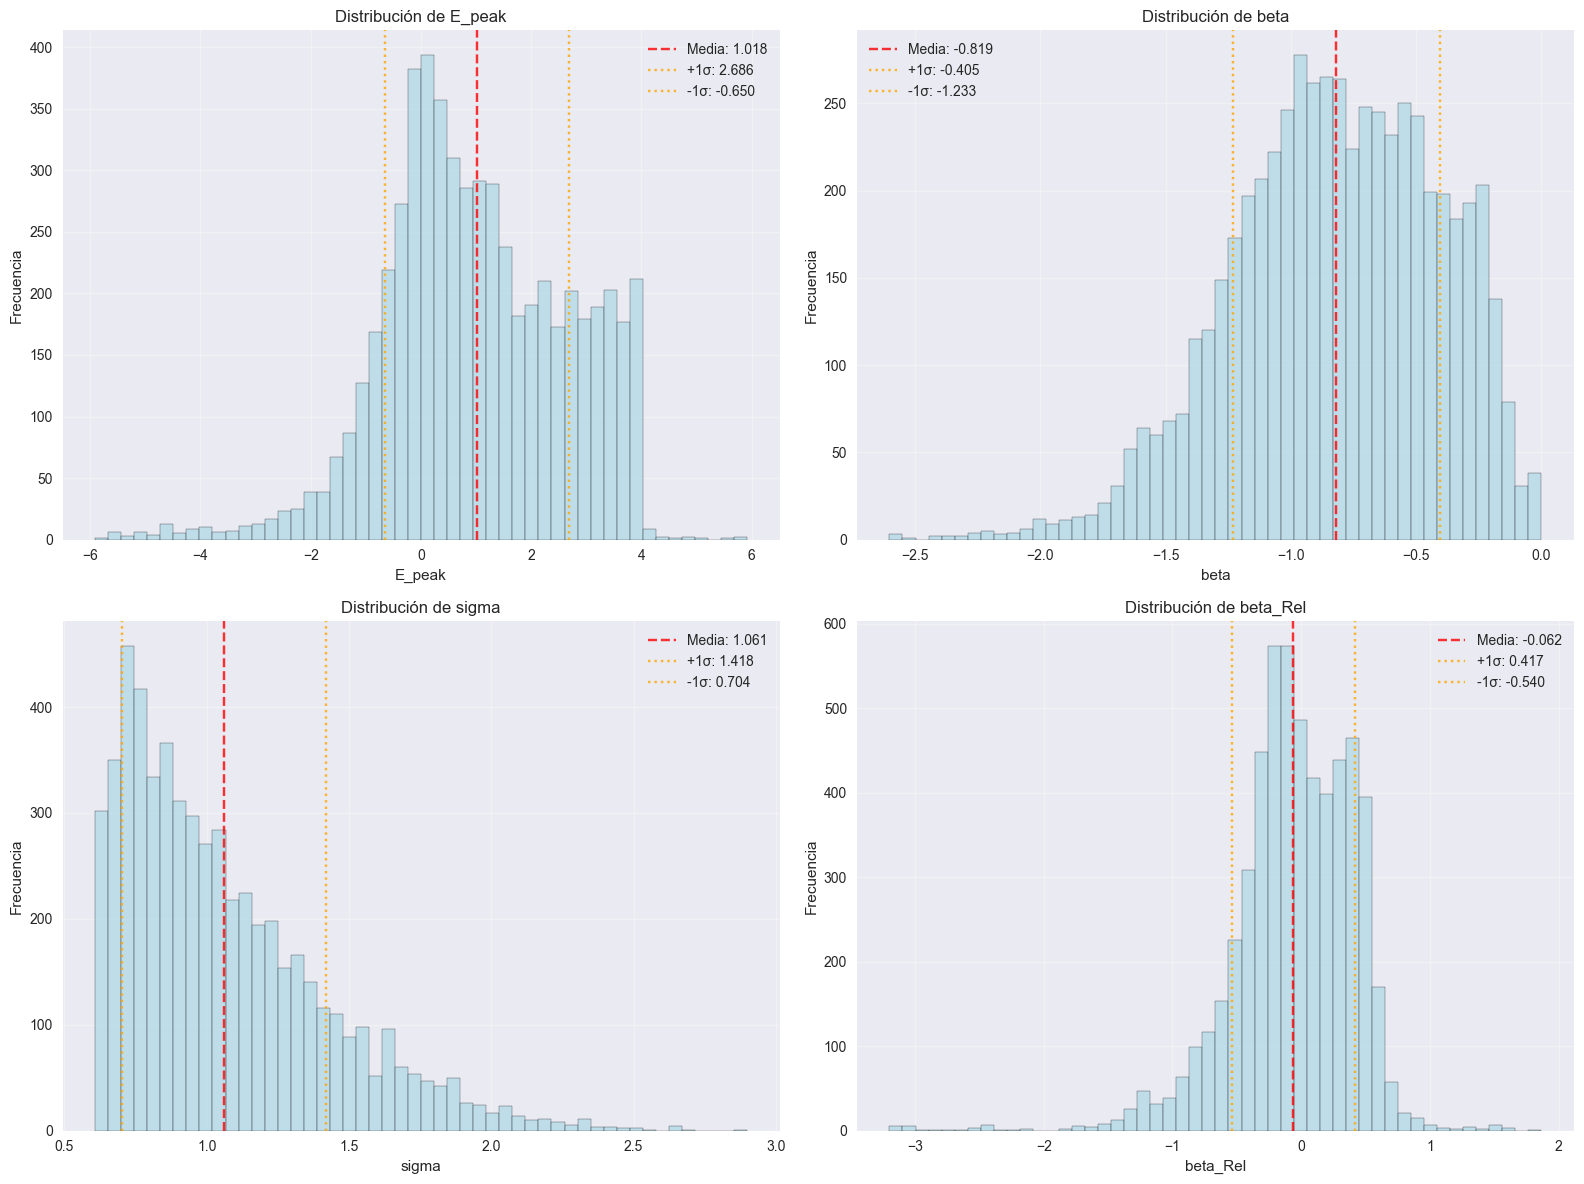

In [116]:
# Variables de características (excluyendo la etiqueta)
feature_cols = ['E_peak', 'beta', 'sigma', 'beta_Rel']

# Histogramas de todas las variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(feature_cols):
    # Histograma general
    axes[i].hist(df[col], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)
    
    # Añadir estadísticas básicas
    mean_val = df[col].mean()
    std_val = df[col].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.3f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.8, label=f'+1σ: {mean_val + std_val:.3f}')
    axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.8, label=f'-1σ: {mean_val - std_val:.3f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

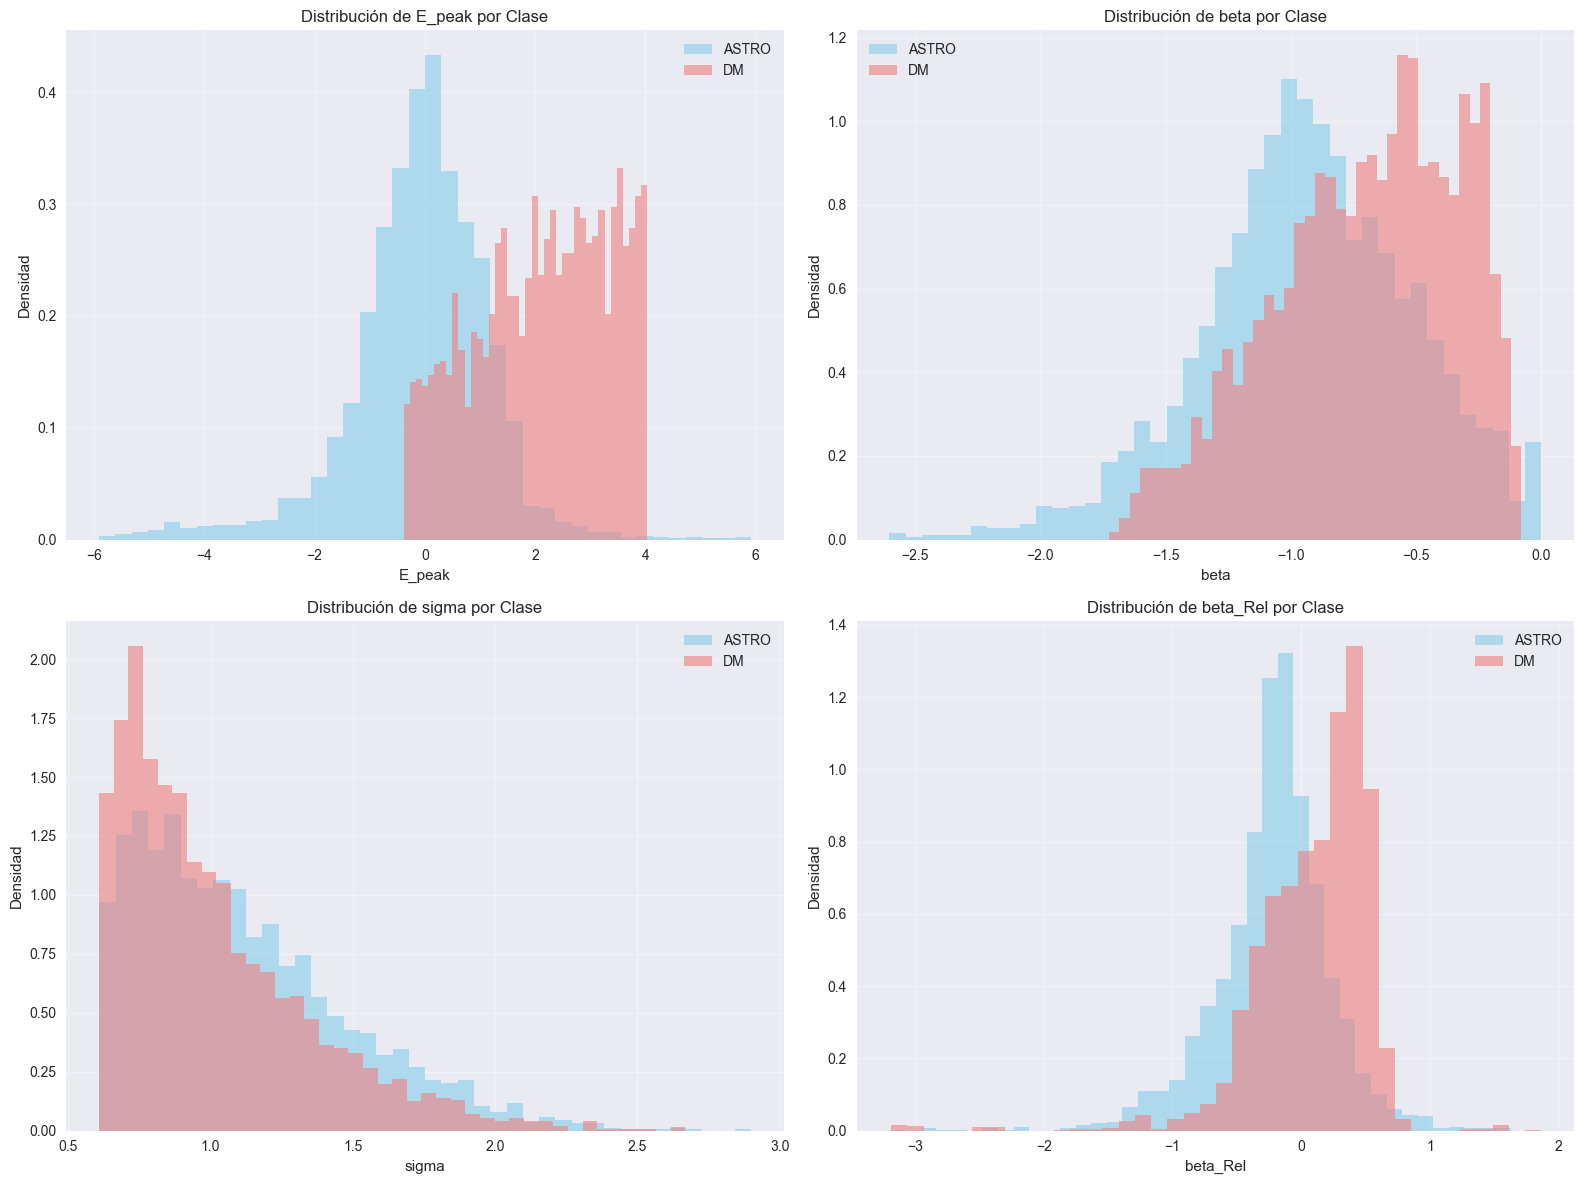

In [117]:
# Histogramas superpuestos por clase
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(feature_cols):
    # Datos por clase
    astro_data = df[df['astro_DM'] == 0.0][col]
    dm_data = df[df['astro_DM'] == 1.0][col]
    
    # Histogramas superpuestos
    axes[i].hist(astro_data, bins=40, alpha=0.6, color='skyblue', label='ASTRO', density=True)
    axes[i].hist(dm_data, bins=40, alpha=0.6, color='lightcoral', label='DM', density=True)
    
    axes[i].set_title(f'Distribución de {col} por Clase')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Matriz de correlación entre variables:
            E_peak      beta     sigma  beta_Rel
E_peak    1.000000  0.108252 -0.116761  0.355409
beta      0.108252  1.000000 -0.106935 -0.294714
sigma    -0.116761 -0.106935  1.000000 -0.347368
beta_Rel  0.355409 -0.294714 -0.347368  1.000000


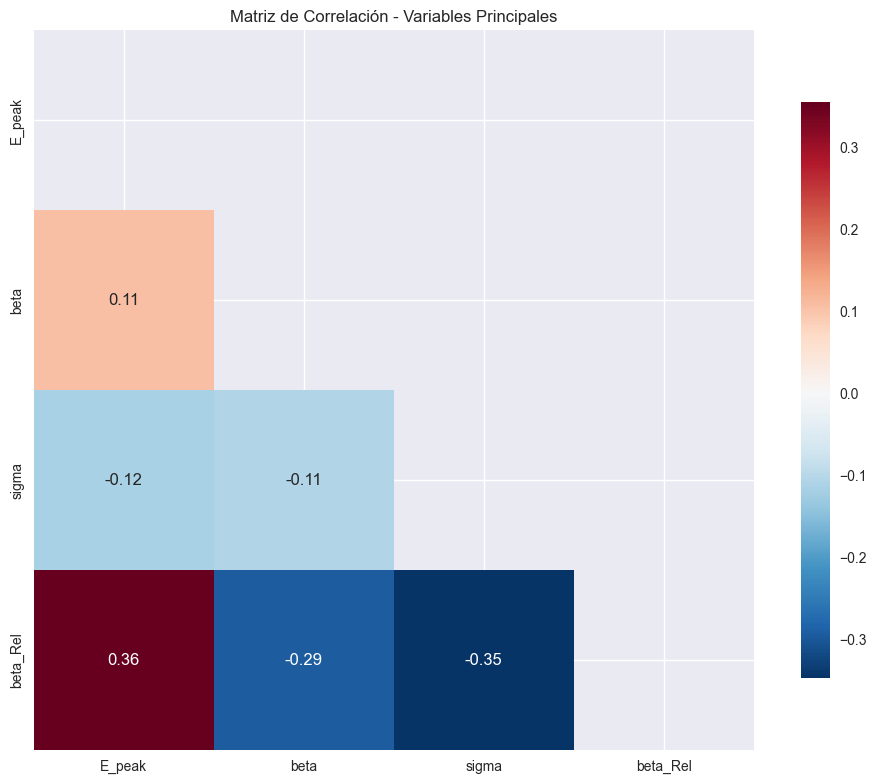

In [118]:
# Matriz de correlación
correlation_matrix = df[feature_cols].corr()
print("Matriz de correlación entre variables:")
print(correlation_matrix)

# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, mask=mask, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Variables Principales')
plt.tight_layout()
plt.show()

In [119]:

# Identificar correlaciones fuertes
print("\nCorrelaciones significativas (|r| > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {corr_val:.3f}")


Correlaciones significativas (|r| > 0.5):


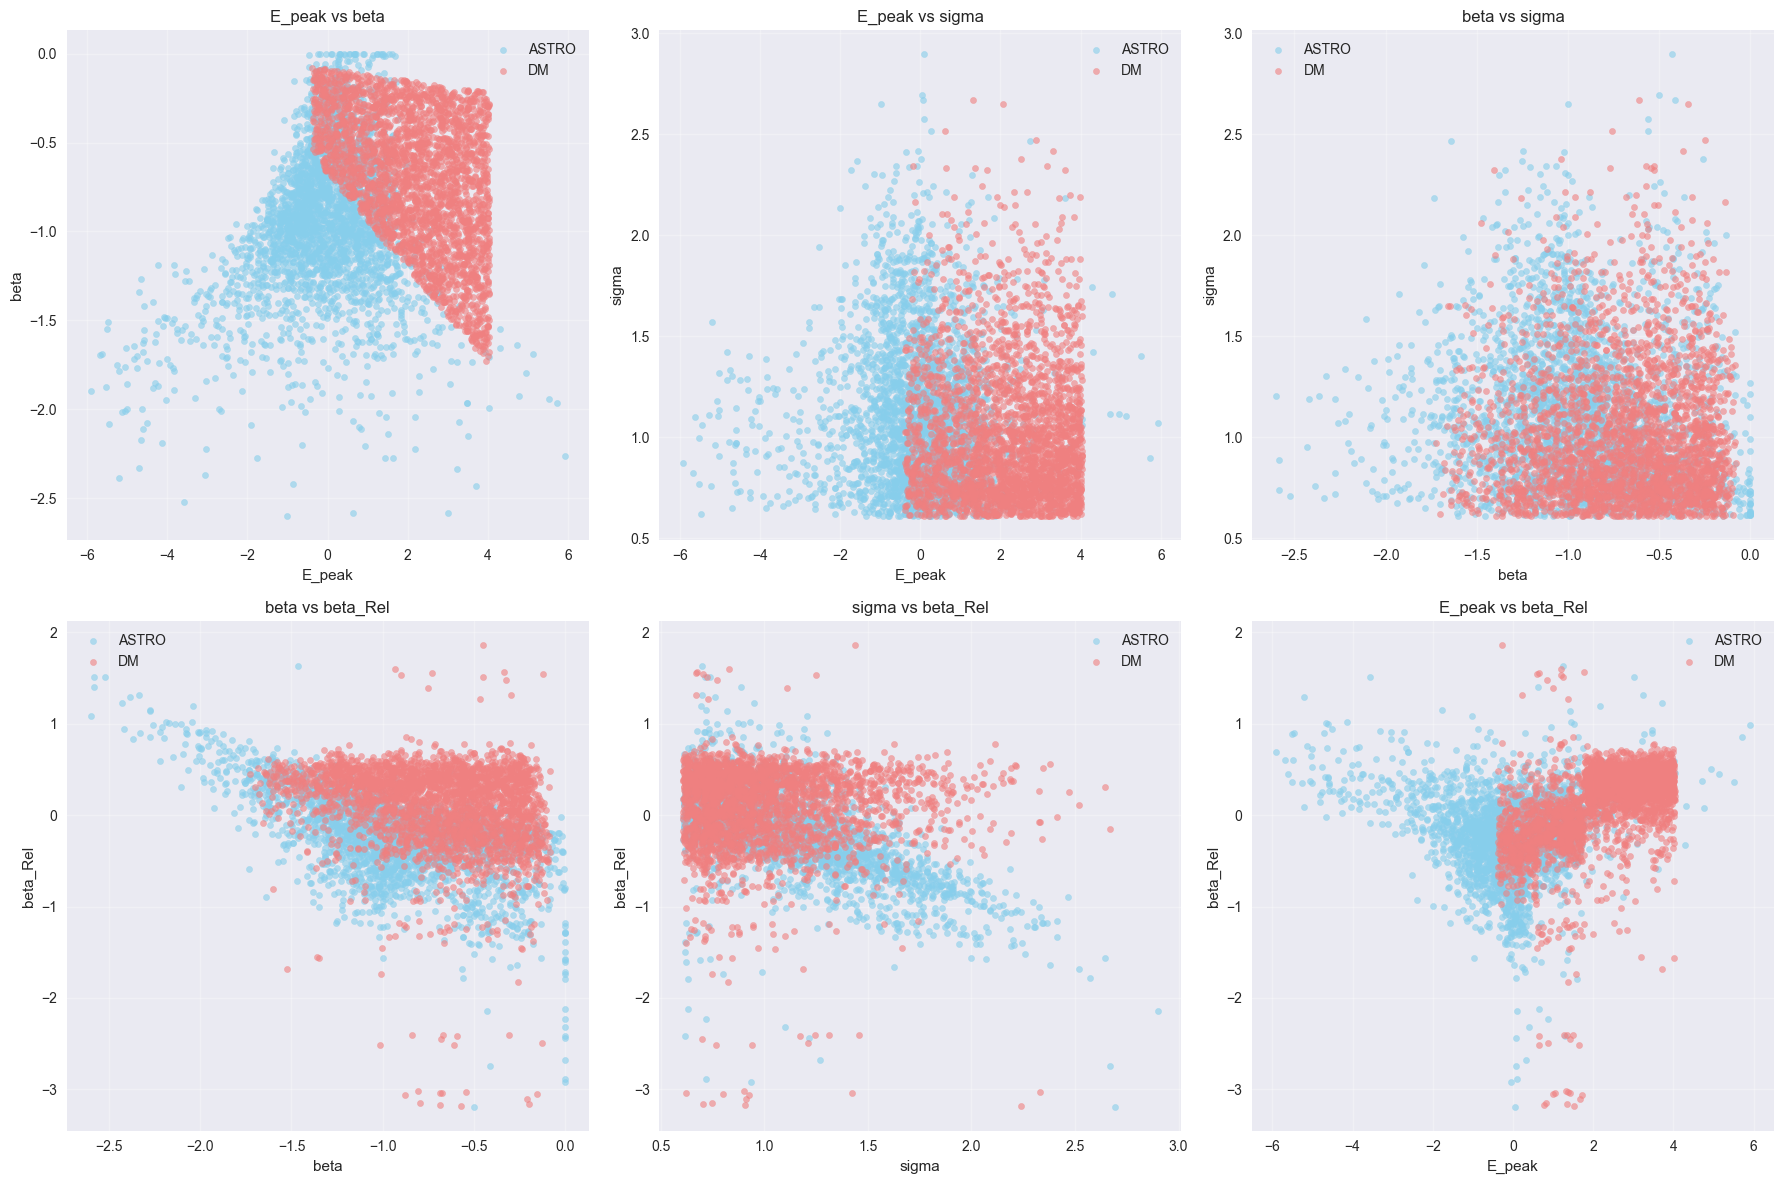

In [120]:
# Crear scatter plots para pares de variables más interesantes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Pares de variables importantes
pairs = [
    ('E_peak', 'beta'),
    ('E_peak', 'sigma'),
    ('beta', 'sigma'),
    ('beta', 'beta_Rel'),
    ('sigma', 'beta_Rel'),
    ('E_peak', 'beta_Rel')
]

for i, (x_var, y_var) in enumerate(pairs):
    # Separar por clase
    astro_data = df[df['astro_DM'] == 0.0]
    dm_data = df[df['astro_DM'] == 1.0]
    
    # Scatter plot
    axes[i].scatter(astro_data[x_var], astro_data[y_var], alpha=0.6, 
                   c='skyblue', label='ASTRO', s=20)
    axes[i].scatter(dm_data[x_var], dm_data[y_var], alpha=0.6, 
                   c='lightcoral', label='DM', s=20)
    
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel(y_var)
    axes[i].set_title(f'{x_var} vs {y_var}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()